In [1]:
%matplotlib inline

# Digital Comics Data Analysis (Python) - Marvel or DC?

## Introduction

After having done the analysis of the website ([post here](http://felipegalvao.com.br/blog/2016/05/01/comixology-digital-comics-analysis-part-1-analysis-of-site-for-web-scraping/) and the web scraping of the data from the Comixology website ([post here](http://felipegalvao.com.br/blog/2016/05/24/web-scraping-with-python-scraping-digital-comics-information-from-comixology/), we will analyze the data that we got using Python (Pandas).

Let's find out what publisher have the best average ratings and prices, the average page count of the Vamos descobrir quais editoras tem os melhores preços relativos à quantidade de páginas de seus comics, as editoras com as melhores avaliações médias, além de uma análise mais profunda do duelo das gigantes: Marvel x DC Comics. Vamos começar.

## Initial Preparation

First, as usual, let's import the packages we need. With the warning package we will ignore the eventual warning messages that Python / Pandas give to us, so the code in our notebook does not get very long. For the other packages, they are old friends: numpy, pandas, matplotlib and seaborn. Then, we will read the csv file with the read_csv function from Pandas.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

comixology_df = pd.read_csv("comixology_comics_dataset_19.04.2016.csv", 
                            encoding = "ISO-8859-1")

Now, let's create a new column, price per page. This column will help us compare the price of comics that have a different number of pages, and, therefore, should have a bigger price. But how much bigger?

For some comics, the page count information is not available, and so, for these cases, Pandas will return inf as the value of the column, representing an infinite value. For these comics, we will set the price per page as NaN:

In [3]:
# Create price per page column
comixology_df['Price_per_page'] = pd.Series(comixology_df['Original_price'] / 
                                            comixology_df['Page Count'], 
                                            index=comixology_df.index)
                                            
# Define price_per_page as NaN for comics with no information about page count
comixology_df.Price_per_page[comixology_df['Price_per_page'] == np.inf] = np.nan

Now, let's use the iterrows() function of the DataFrame to extract the publishing year of the print version of the comic. This function creates a for loop that iterates over each row of the DataFrame. Let's use the split() function to turn the string that contains the print release date into a list of values, and the third one will be the year. In some cases, this will return a value bigger than 2016, and since this is impossible, we will define these cases as NaN:

In [4]:
# Extract the year of release for print version
print_dates = []
for index, row in comixology_df.iterrows():
    if type(comixology_df.ix[index]['Print Release Date']) == float:
        row_year = np.nan
    else:        
        row_year = int(comixology_df.ix[index]['Print Release Date'].split()[2])
        if row_year > 2016:
            row_year = np.nan
    print_dates.append(row_year)

comixology_df['Print_Release_Year'] = pd.Series(print_dates, 
                                                index=comixology_df.index)

## To the analysis (and beyond!)

The first analysis we'll do is the calculation of some average values of the website, like average price of comics, average page count, among others. We'll use the nanmean() function from numpy. This function calculates the mean of a series os values, not considering NaN cases.

In [5]:
# Calculate some average values of the site
average_price = np.nanmean(comixology_df['Original_price'])
average_page_count = np.nanmean(comixology_df['Page Count'])
average_rating = np.nanmean(comixology_df['Rating'])
average_rating_quantity = np.nanmean(comixology_df['Ratings_Quantity'])
average_price_per_page = np.nanmean(comixology_df['Price_per_page'])

print("Average Price: " + str(average_price))
print("Average Page Count: " + str(average_page_count))
print("Average Rating: " + str(average_rating))
print("Average Ratings Quantity: " + 
      str(average_rating_quantity))
print("Average Price Per Page: " + str(average_price_per_page))

Average Price: 3.69789045383
Average Page Count: 51.5862786864
Average Rating: 4.26347617558
Average Ratings Quantity: 51.5088270335
Average Price Per Page: 0.0805173472536


Now, we will define the maximum number of columns for each field in the printing of the table to 40 columns. We'll do that because the name of some comics is long, and the printing of the table can get a little strange. With this configuration we can see more information in one row.

After that, let's list comics with an average rating of 5 stars, that have more than 20 ratings (to consider only the more representative comics; comics with an average rating of 5 stars but with only one rating are not a very good metric), and let's sort it by price per page. In the top, we will have some free comics (the 6 first ones). Then, we will have great comics, in the eyes of the users, that have a very good price.</p>

In [6]:
# Define number of columns for table printing
pd.set_option('display.max_colwidth', 40)

In [7]:
# List comics with 5 stars rating that have at least 20 ratings
comics_with_5_stars = comixology_df[comixology_df.Rating == 5]
comics_with_5_stars = comics_with_5_stars[comics_with_5_stars.Ratings_Quantity 
                                          > 20]
# Print comics sorted by price per page
print(comics_with_5_stars[['Name','Publisher','Price_per_page']].
      sort_values(by='Price_per_page')) 

                                          Name                     Publisher  \
44099               Left 4 Dead: The Sacrifice                         Valve   
6143                      Looking For Group #1                 Blind Ferret    
55253                      The Walking Dead #1              Image - Skybound   
30295  FCBD 2014: Don Rosa's Uncle Scrooge ...                 Fantagraphics   
8762                   Mother Russia #1 (of 3)  Alterna Comics - FUBAR Press   
80022  Scott Pilgrim Vol. 1: Scott Pilgrim'...                     Oni Press   
50270       Transformers: The Cover Collection                           IDW   
42749                        American Elf 2001         Top Shelf Productions   
42748                        American Elf 2000         Top Shelf Productions   
7677           Cerebus Vol. 2 #2: High Society             Aardvark-Vanaheim   
81547                     Heart of a Corpse #2                           SLG   
7679           Cerebus Vol. 2 #4: High S

In the next analysis, we will use only comics with more than 5 ratings. For that, we will filter the DataFrame. Then, we'll create a Pandas pivot table, so that we can visualize the quantity of comics with ratings and the average rating of this publisher. Then, we will consider as representative publishers those that have at least 20 comics with ratings. To do that, we will filter the pivot table. And finally, we will sort this table by average rating, going from the highest to the lowest. This means that the publishers on the top of the table will be the ones that have the best average rating from its comics.

In [8]:
# Filter the original DataFrame for comics with more than 5 ratings
comics_more_than_5_ratings = comixology_df[comixology_df.Ratings_Quantity > 5]

# Create pivot table with average rating by publisher
publishers_avg_rating = pd.pivot_table(comics_more_than_5_ratings, 
                                       values=['Rating'], 
                                       index=['Publisher'], 
                                       aggfunc=[np.mean, np.count_nonzero])

# Filter for any Publisher that has more than 20 comics rated
main_pub_avg_rating = publishers_avg_rating[publishers_avg_rating.
                                            count_nonzero.Rating > 20]
main_pub_avg_rating = main_pub_avg_rating.sort_values(by=('mean','Rating'), 
                                                      ascending=False)
print(main_pub_avg_rating)

                                        mean count_nonzero
                                      Rating        Rating
Publisher                                                 
Cartoon Books                       4.875000          80.0
Aardvark-Vanaheim                   4.800000          25.0
Abstract Studio                     4.786517          89.0
BOOM! - BOOM! Box                   4.763889          72.0
Archie                              4.711656         326.0
Icon                                4.585859         198.0
Evil Twin Comics                    4.565217          23.0
Udon                                4.561798          89.0
MAX                                 4.546911         437.0
Fantagraphics                       4.518182         110.0
Image - Skybound                    4.504092         611.0
ComixTribe                          4.500000          32.0
Kodansha                            4.487179          39.0
Delcourt                            4.463415          41

Note that the giants, Marvel and DC Comics, are not among the ones in the top. If we see the complete table, they are between the middle and the bottom of the table.

To help in the visualization, let's create a matplotlib chart that represents the table above:

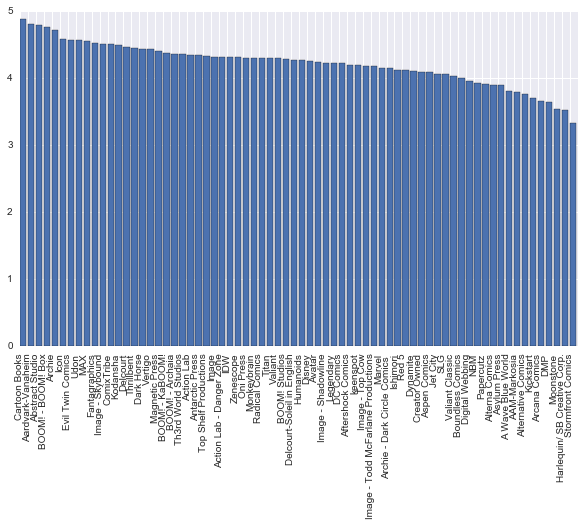

In [9]:
# Create chart with average ratings for the Publishers
plt.figure(figsize=(10, 6))
y_axis = main_pub_avg_rating['mean']['Rating']
x_axis = range(len(y_axis))

plt.bar(x_axis, y_axis)
plt.xticks(x_axis, tuple(main_pub_avg_rating.index),rotation=90)
plt.show()

To simplify and have a better table and chart, let's consider now only the publishers that have 300 comics with ratings. First, the table:

In [10]:
# Filter for Publishers that have more than 300 comics rated
big_pub_avg_rating = publishers_avg_rating[publishers_avg_rating.
                                           count_nonzero.Rating > 300]
big_pub_avg_rating = big_pub_avg_rating.sort_values(by=('mean','Rating'), 
                                                    ascending=False)
print(big_pub_avg_rating)

                                        mean count_nonzero
                                      Rating        Rating
Publisher                                                 
Archie                              4.711656         326.0
MAX                                 4.546911         437.0
Image - Skybound                    4.504092         611.0
Dark Horse                          4.440000         550.0
Vertigo                             4.435793        2453.0
Image                               4.316908        3105.0
IDW                                 4.313492        2772.0
Zenescope                           4.309711         381.0
Oni Press                           4.305376         465.0
Valiant                             4.291022         323.0
BOOM! Studios                       4.277219        1194.0
Avatar                              4.234672         473.0
DC Comics                           4.218644       13012.0
Image - Top Cow                     4.176545         793

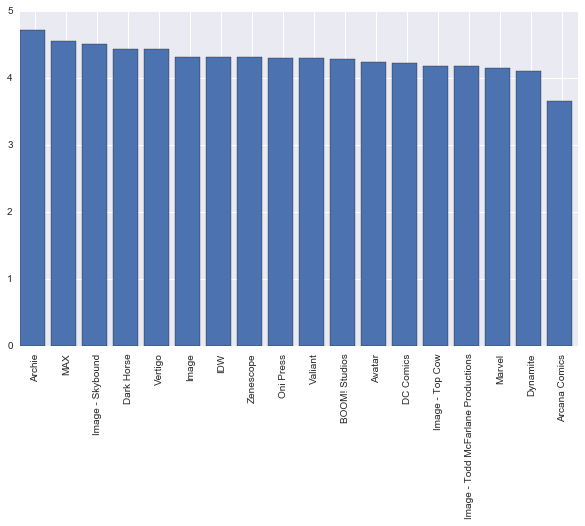

In [11]:
# Create chart with average ratings for Publishers with more than 300 comics 
# rated
plt.figure(figsize=(10, 6))
y_axis = big_pub_avg_rating['mean']['Rating']
x_axis = np.arange(len(y_axis))

plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.5, tuple(big_pub_avg_rating.index), rotation=90)
plt.show()

One thing that I believed that could make a difference in the ratings of a comic was the age classification. Were comics made to the adults rated better? Or worse? Let's check that making another pivot table:

In [12]:
# Create pivot table with Rating by Age Rating
rating_by_age = pd.pivot_table(comics_more_than_5_ratings, 
                               values=['Rating'], 
                               index=['Age Rating'], 
                               aggfunc=[np.mean, np.count_nonzero])
                               
print(rating_by_age)

                mean count_nonzero
              Rating        Rating
Age Rating                        
12+ Only    4.185380       28304.0
15+ Only    4.218854        4487.0
17+ Only    4.341259        9925.0
18+ Only    4.143939         264.0
9+ Only     4.360186        1502.0
All Ages    4.395935        1230.0


And below, the corresponding chart:

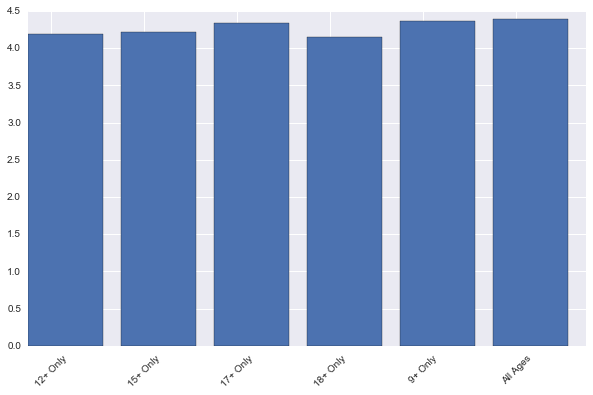

In [13]:
# Bar Chart with rating by age rating
plt.figure(figsize=(10, 6))
y_axis = rating_by_age['mean']['Rating']
x_axis = np.arange(len(y_axis))

plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.25, tuple(rating_by_age.index), rotation=45)
plt.show()

As we can see, the height of the bars is quite similar. It seems that the age classification does not make a significant effect on the ratings of a comic. If we see it with a purely mathematical view, comics with an age classification for 9+ years or for all ages get the best ratings, by a small margin. But it is not possible to view a strong relation, since it does not varies in the same way as the age classification increases or decreases.

Our next step is to see how the release of comics evolved (considering print versions) over the years. Remember that we already created a column with the year of release of the print version of the comic. The next step is basically to count the occurrences of each year in this column. Let's make a list with the years and then count the releases per year:

In [14]:
# Create pivot table with print releases per year
print_releases_per_year = pd.pivot_table(comixology_df, 
                                         values=['Name'], 
                                         index=['Print_Release_Year'], 
                                         aggfunc=[np.count_nonzero])
print_years = []
for index, row in print_releases_per_year.iterrows():    
    print_year = int(index)
    print_years.append(print_year)
print_releases_per_year.index = print_years
print(print_releases_per_year)

     count_nonzero
              Name
1900            14
1938             1
1939             6
1940             7
1941            21
1942            22
1943            18
1944            13
1945            13
1946            15
1947             4
1948            11
1949            14
1950             7
1951             2
1952             4
1953             3
1954             6
1955             9
1956             8
1957             9
1958             6
1959            13
1960            17
1961            29
1962            45
1963            74
1964            71
1965            58
1966            63
...            ...
1987           243
1988           281
1989           248
1990           302
1991           353
1992           402
1993           537
1994           630
1995           599
1996           499
1997           605
1998           664
1999           727
2000           771
2001           676
2002           714
2003           876
2004          1151
2005          1365
2006        

And now let's create the cart to see the situation better:

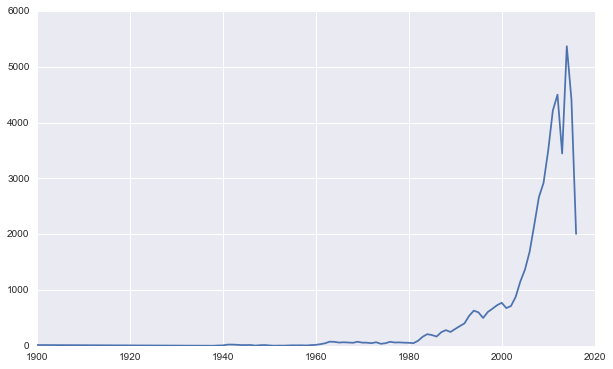

In [15]:
# Create chart with print releases per year
y_axis = print_releases_per_year['count_nonzero']['Name']
x_axis = print_releases_per_year['count_nonzero']['Name'].index
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_axis)
plt.show()

The numbers show that the growing was moderate, until the decade of 2000, when a boom happened, with a great increase in releases until 2012, when the release numbers started to oscillate. The fall shown in 2016 is because we are still in the middle of the year.

Now we'll go on to make an evaluation of the most rated comics on the website. We can also probably say that these are the most read comics on the website. So, for this analysis, we will check the comics with most ratings, sorting the table and printing some columns. Let's see the 30 first ones.

In [16]:
# Sort the DataFrame by ratings quantity and show Name, Publisher and quantity
comics_by_ratings_quantity = comixology_df[['Name','Publisher',
                                            'Ratings_Quantity']].sort_values(
                                            by='Ratings_Quantity', 
                                            ascending=False)
print(comics_by_ratings_quantity.head(30))

                                          Name         Publisher  \
55253                      The Walking Dead #1  Image - Skybound   
41479    Arrow (2012-2013) #1: Special Edition         DC Comics   
53325                                  Saga #1             Image   
11898                                 Bane 101         DC Comics   
16638       Injustice: Gods Among Us (2013) #1         DC Comics   
12709                        Batman (2011-) #1         DC Comics   
17286                Justice League (2011-) #1         DC Comics   
55228   The Walking Dead Vol. 1: Days Gone Bye  Image - Skybound   
19435     Batman: Night of the Owls Booklet #1         DC Comics   
549    Batman Black & White: A Black and Wh...         DC Comics   
231                                 Batman 101         DC Comics   
2246                         Blackest Night #0         DC Comics   
61309       Amazing Spider-Man (1999-2013) #36            Marvel   
49490          Teenage Mutant Ninja Turtles #1  

And the chart with the most rated comics:

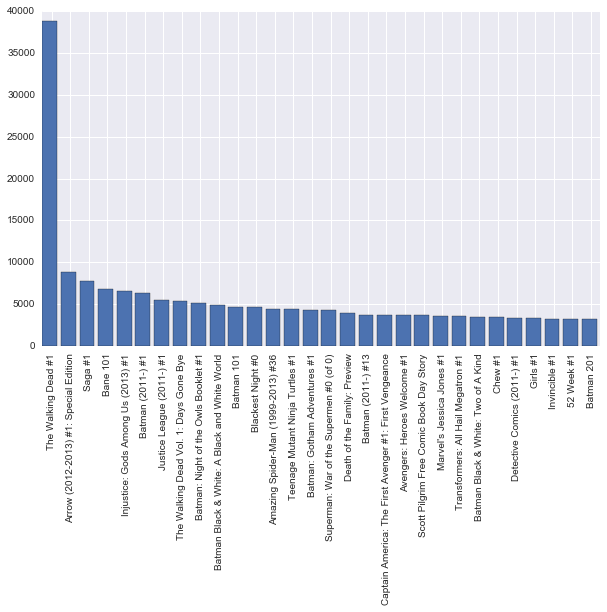

In [17]:
# Create chart with the previously sorted comics
plt.figure(figsize=(10, 6))
y_axis = comics_by_ratings_quantity.head(30)['Ratings_Quantity']
x_axis = np.arange(len(y_axis))

plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.5, tuple(comics_by_ratings_quantity.head(30)['Name']), 
           rotation=90)
plt.show()

Walking Dead is by far the one with most ratings. After that, some Marvel and DC comics and then some varied ones.</p>

Now, let's make our detailed analysis on the giant publishers: Marvel and DC Comics.

## Marvel vs DC Comics

First, let's filter the DataFrame, so that only comics from these two remain. After that, we will calculate some average values of these two using a pivot table:

In [18]:
# Filter the DataFrame for comics from Marvel or DC Comics
marvel_dc_comics = comixology_df[(comixology_df.Publisher == 'Marvel') | 
                                 (comixology_df.Publisher == 'DC Comics')]
 
# Create pivot table with Primeiro, alguns valores médios de cada uma                                
marvel_dc_pivot_averages = pd.pivot_table(marvel_dc_comics, 
                               values=['Rating','Original_price','Page Count',
                                       'Price_per_page'], 
                               index=['Publisher'], 
                               aggfunc=[np.mean])
print(marvel_dc_pivot_averages)

                    mean                                    
          Original_price Page Count Price_per_page    Rating
Publisher                                                   
DC Comics       2.600034  35.318463       0.078356  4.233034
Marvel          3.398555  41.344295       0.090946  4.191335


As we can see, DC Comics has a lower average price and price per page, and an average rating slightly higher. The average page count is a little higher on Marvel. Below, the bar charts that represent these comparations:

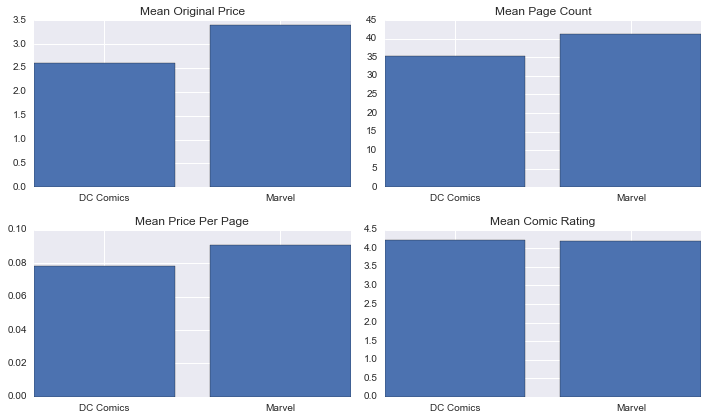

In [19]:
# Charts for average values for Marvel and DC
plt.figure(1,figsize=(10, 6))

plt.subplot(221) # Mean original price
y_axis = marvel_dc_pivot_averages['mean']['Original_price']
x_axis = np.arange(len(marvel_dc_pivot_averages['mean']['Original_price']))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, 
           tuple(marvel_dc_pivot_averages['mean']['Original_price'].index))
plt.title('Mean Original Price')
plt.tight_layout()

plt.subplot(222) # Mean page count
y_axis = marvel_dc_pivot_averages['mean']['Page Count']
x_axis = np.arange(len(marvel_dc_pivot_averages['mean']['Page Count']))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, 
           tuple(marvel_dc_pivot_averages['mean']['Page Count'].index))
plt.title('Mean Page Count')
plt.tight_layout()

plt.subplot(223) # Mean Price Per Page
y_axis = marvel_dc_pivot_averages['mean']['Price_per_page']
x_axis = np.arange(len(marvel_dc_pivot_averages['mean']['Price_per_page']))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, 
           tuple(marvel_dc_pivot_averages['mean']['Price_per_page'].index))
plt.title('Mean Price Per Page')
plt.tight_layout()

plt.subplot(224) # Mean Comic Rating
y_axis = marvel_dc_pivot_averages['mean']['Rating']
x_axis = np.arange(len(marvel_dc_pivot_averages['mean']['Rating']))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, 
           tuple(marvel_dc_pivot_averages['mean']['Rating'].index))
plt.title('Mean Comic Rating')
plt.tight_layout()

plt.show()

Next step is to see some numbers related to the quantity of comics that each have. How many comics each publisher has, how many of them are good (4 or 5 stars rating), how many are bad (1 or 2 stars) and the proportion of these to the total. For this analysis, we will basically filter the DataFrame and count the number of rows of each filtered view. Simple:

In [20]:
# Calculate total number of comics for each Publisher, proportion of comics 
# with rating 4 or bigger and proportion of comics with rating 2 or smaller
marvel_total = len(marvel_dc_comics[marvel_dc_comics['Publisher'] == 'Marvel'])
marvel_4_or_5 = len(marvel_dc_comics[(marvel_dc_comics['Publisher'] == 'Marvel')
                                     & (marvel_dc_comics['Rating'] >= 4)])
marvel_proportion_4_or_5 = marvel_4_or_5 / marvel_total
marvel_1_or_2 = len(marvel_dc_comics[(marvel_dc_comics['Publisher'] == 'Marvel') 
                                     & (marvel_dc_comics['Rating'] <= 2)])
marvel_proportion_1_or_2 = marvel_1_or_2 / marvel_total

dc_total = len(marvel_dc_comics[marvel_dc_comics['Publisher'] == 'DC Comics'])
dc_4_or_5 = len(marvel_dc_comics[(marvel_dc_comics['Publisher'] == 'DC Comics')
                                 & (marvel_dc_comics['Rating'] >= 4)])
dc_proportion_4_or_5 = dc_4_or_5 / dc_total
dc_1_or_2 = len(marvel_dc_comics[(marvel_dc_comics['Publisher'] == 'DC Comics') 
                                 & (marvel_dc_comics['Rating'] <= 2)])
dc_proportion_1_or_2 = dc_1_or_2 / dc_total

print("\n")
print("Marvel's Total Comics: " + str(marvel_total))
print("Marvel's comics with rating 4 or bigger: " + 
      str(marvel_4_or_5))
print("Proportion of Marvel's comics with rating 4 or bigger: " + 
      str("{0:.2f}%".format(marvel_proportion_4_or_5 * 100)))
print("Marvel's comics with rating 2 or smaller: " + 
      str(marvel_1_or_2))
print("Proportion of Marvel's comics with rating 2 or smaller: " + 
      str("{0:.2f}%".format(marvel_proportion_1_or_2 * 100)))
print("\n")
print("DC's Total Comics: " + str(dc_total))
print("DC's comics with rating 4 or bigger: " + 
      str(dc_4_or_5))
print("Proportion of DC's comics with rating 4 or bigger: " + 
      str("{0:.2f}%".format(dc_proportion_4_or_5 * 100)))
print("DC's comics with rating 2 or smaller: " + 
      str(dc_1_or_2))
print("Proportion of DC's comis with rating 2 or smaller: " + 
      str("{0:.2f}%".format(dc_proportion_1_or_2 * 100)))
print("\n")



Marvel's Total Comics: 18063
Marvel's comics with rating 4 or bigger: 14791
Proportion of Marvel's comics with rating 4 or bigger: 81.89%
Marvel's comics with rating 2 or smaller: 95
Proportion of Marvel's comics with rating 2 or smaller: 0.53%


DC's Total Comics: 17440
DC's comics with rating 4 or bigger: 15986
Proportion of DC's comics with rating 4 or bigger: 91.66%
DC's comics with rating 2 or smaller: 62
Proportion of DC's comis with rating 2 or smaller: 0.36%




Again, here, DC Comics comes a little better. DC shows a bigger proportion of good comics and a smaller proportion of bad comics. DC scores one more. Below, the chart with the comparisons:

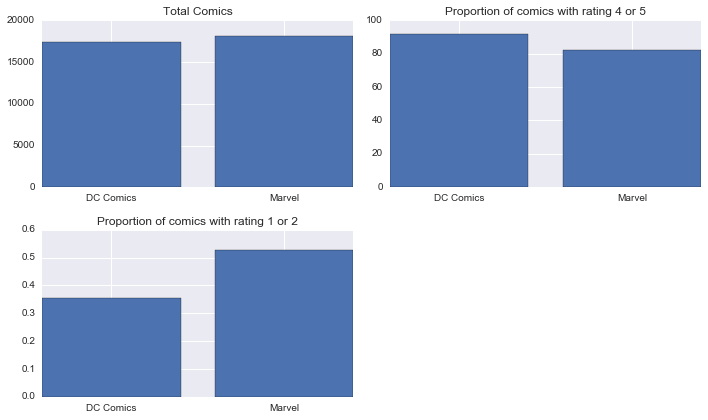

In [21]:
# Create charts with total comics and previously calculated proportions for 
# Marvel and DC
plt.figure(2,figsize=(10, 6))

plt.subplot(221) # Total comics for Marvel and DC
y_axis = [dc_total, marvel_total]
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, ('DC Comics','Marvel'))
plt.title('Total Comics')
plt.tight_layout()

plt.subplot(222) # Proportion of comics with rating 4 or 5
y_axis = [dc_proportion_4_or_5 * 100, marvel_proportion_4_or_5 * 100]
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, ('DC Comics','Marvel'))
plt.title('Proportion of comics with rating 4 or 5')
plt.tight_layout()

plt.subplot(223) # Proportion of comics with rating 1 or 2
y_axis = [dc_proportion_1_or_2 * 100, marvel_proportion_1_or_2 * 100]
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, ('DC Comics','Marvel'))
plt.title('Proportion of comics with rating 1 or 2')
plt.tight_layout()

plt.show()

Just as curiosity, let's check the number of ratings in comics of each publisher, through another pivot table:

In [22]:
# Create Pivot Table with quantity of ratings of each Publisher
marvel_dc_pivot_sums = pd.pivot_table(marvel_dc_comics, 
                               values=['Ratings_Quantity'], 
                               index=['Publisher'], 
                               aggfunc=[np.sum])
print(marvel_dc_pivot_sums)

                       sum
          Ratings_Quantity
Publisher                 
DC Comics          1725344
Marvel             1099324


Interesting to note that even with Marvel having more comics, as we saw in the previous table, there quantity of ratings of DC's comics is way bigger, approximately 55% more. It seems that DC's fans are more propense to rate comics in Comixology than Marvel ones.

Our next evaluation will be about characters and teams of heroes / villains. First, we need to create lists of characters and teams for each publisher. I created the lists by hand, doing some research. It didn't took very long.

In [23]:
# Define list of characters and teams of DC and Marvel
main_dc_characters = ['Superman','Batman','Aquaman','Wonder Woman', 'Flash', 
                      'Robin','Arrow', 'Batgirl', 'Bane', 'Harley Queen', 
                      'Poison Ivy', 'Joker','Firestorm','Vixen',
                      'Martian Manhunter','Zod','Penguin','Lex Luthor',
                      'Green Lantern','Supergirl','Atom','Cyborg','Hawkgirl',
                      'Starfire','Jonah Hex','Booster Gold','Black Canary',
                      'Shazam','Catwoman','Nightwing','Zatanna','Hawkman',
                      'Power Girl','Rorschach','Doctor Manhattan',
                      'Blue Beetle','Batwoman','Darkseid','Vandal Savage', 
                      "Ra's Al Ghul",'Riddler','Reverse Flash','Black Adam',
                      'Deathstroke','Brainiac','Sinestro','Two-Face']
                      
main_marvel_characters = ['Spider-Man','Captain Marvel','Hulk','Thor',
                          'Iron Man','Luke Cage','Black Widow','Daredevil',
                          'Captain America','Jessica Jones','Ghost Rider',
                          'Spider-Woman','Silver Surfer','Beast','Thing',
                          'Kitty Pride','Doctor Strange','Black Panther',
                          'Invisible Woman','Nick Fury','Storm','Professor X',
                          'Cyclops','Jean Grey','Wolverine','Scarlet Witch',
                          'Gambit','Rogue','X-23','Iceman','She-Hulk',
                          'Iron Fist','Hawkeye','Quicksilver','Vision',
                          'Ant-Man','Cable','Bishop','Colossus','Deadpool',
                          'Human Torch','Mr. Fantastic','Nightcrawler','Nova',
                          'Psylocke','Punisher','Rocket Raccoon','Groot',
                          'Star-Lord','War Machine','Gamora','Drax','Venom',
                          'Carnage','Octopus','Green Goblin','Abomination',
                          'Enchantress','Sentinel','Viper','Lady Deathstrike',
                          'Annihilus','Ultron','Galactus','Kang','Bullseye',
                          'Juggernaut','Sabretooth','Mystique','Kingpin',
                          'Apocalypse','Thanos','Dark Phoenix','Loki',
                          'Red Skull','Magneto','Doctor Doom','Ronan']
                          
dc_teams = ['Justice League','Teen Titans','Justice Society','Lantern Corps',
            'Legion of Super-Heroes','All-Star Squadron','Suicide Squad',
            'Birds of Prey','Gen13', 'The League of Extraordinary Gentlemen',
            'Watchmen']
            
marvel_teams = ['X-Men','Avengers','Fantastic Four','Asgardian Gods','Skrulls',
                'S.H.I.E.L.D.','Inhumans','A.I.M.','X-Factor','X-Force',
                'Defenders','New Mutants','Brotherhood of Evil Mutants',
                'Thunderbolts', 'Alpha Flight','Guardians of the Galaxy',
                'Nova Corps','Illuminati']

Next, we need to pass each name of character or team. First, let's define a DataFrame, and we'll filter so that the only rows that remain are the ones where the comic name includes the name of this character or team. Then, we'll extract some information from there. The quantity of comics will be the number of rows of the resulting DataFrame. Then, we will get the average price, rating and page count. All this information will be saved in a dictionary, and this dictionary will be appended to a character list, if it is a character, or a team list, if it is a team. In the end, we will have a list of dictionaries for characters and one for teams, and we will use them to create DataFrames:

In [24]:
# Create empty list and dict to hold character info
character_row = {}
characters_dicts = []

for character in main_dc_characters:
    character_df = comixology_df[(comixology_df['Name'].str.contains(character)) & 
                                 (comixology_df['Publisher'] == 'DC Comics')]
    character_row['Character_Name'] = character
    character_row['Quantity_of_comics'] = len(character_df)
    character_row['Average_Rating'] = np.nanmean(character_df['Rating'])
    character_row['Average_Price'] = np.nanmean(character_df['Original_price'])
    character_row['Average_Pages'] = np.nanmean(character_df['Page Count'])
    character_row['Publisher'] = "DC Comics"
    characters_dicts.append(character_row)
    character_row = {}
    
for character in main_marvel_characters:
    character_df = comixology_df[(comixology_df['Name'].str.contains(character)) & 
                                 (comixology_df['Publisher'] == 'Marvel')]
    character_row['Character_Name'] = character
    character_row['Quantity_of_comics'] = len(character_df)
    character_row['Average_Rating'] = np.nanmean(character_df['Rating'])
    character_row['Average_Price'] = np.nanmean(character_df['Original_price'])
    character_row['Average_Pages'] = np.nanmean(character_df['Page Count'])
    character_row['Publisher'] = "Marvel"
    characters_dicts.append(character_row)
    character_row = {}
    
characters_df = pd.DataFrame(characters_dicts)

In [25]:
# Create empty list and dict to hold team info
team_row = {}
teams_dicts = []

for team in dc_teams:
    team_df = comixology_df[(comixology_df['Name'].str.contains(team)) & 
                                 (comixology_df['Publisher'] == 'DC Comics')]
    team_row['Team_Name'] = team
    team_row['Quantity_of_comics'] = len(team_df)
    team_row['Average_Rating'] = np.nanmean(team_df['Rating'])
    team_row['Average_Price'] = np.nanmean(team_df['Original_price'])
    team_row['Average_Pages'] = np.nanmean(team_df['Page Count'])
    team_row['Publisher'] = "DC Comics"
    teams_dicts.append(team_row)
    team_row = {}
    
for team in marvel_teams:
    team_df = comixology_df[(comixology_df['Name'].str.contains(team)) & 
                                 (comixology_df['Publisher'] == 'Marvel')]
    team_row['Team_Name'] = team
    team_row['Quantity_of_comics'] = len(team_df)
    team_row['Average_Rating'] = np.nanmean(team_df['Rating'])
    team_row['Average_Price'] = np.nanmean(team_df['Original_price'])
    team_row['Average_Pages'] = np.nanmean(team_df['Page Count'])
    team_row['Publisher'] = "Marvel"
    teams_dicts.append(team_row)
    team_row = {}
    
teams_df = pd.DataFrame(teams_dicts)

Let's consider only teams and characters that have more than 20 comics where their names are present on the title of the comic. So, let's make a filter:

In [26]:
# Filter characters and teams DataFrame for rows where there are more than 20
# comics where the character / team name is present on the title of the comics
characters_df = characters_df[characters_df['Quantity_of_comics'] > 20]
teams_df = teams_df[teams_df['Quantity_of_comics'] > 20]

Now, let's check the biggest characters and teams in number of comics and average rating. For the characters, even considering the ones with more than 20 comics, there are still too many characters left. So, we'll limit the list to the top 20 characters. For the teams, there is no need, since there are already less than 20. Then, we'll print the tables:

In [27]:
# Limit number of characters to 20
top_characters_by_quantity = characters_df.sort_values(by='Quantity_of_comics',
                                         ascending=False)[['Character_Name',
                                         'Average_Rating',
                                         'Quantity_of_comics']].head(20)
top_characters_by_rating = characters_df.sort_values(by='Average_Rating',
                                         ascending=False)[['Character_Name',
                                         'Average_Rating',
                                         'Quantity_of_comics']].head(20)

top_teams_by_quantity = teams_df.sort_values(by='Quantity_of_comics', 
                                             ascending=False)[['Team_Name',
                                             'Average_Rating',
                                             'Quantity_of_comics']]
top_teams_by_rating = teams_df.sort_values(by='Average_Rating', 
                                           ascending=False)[['Team_Name',
                                           'Average_Rating',
                                           'Quantity_of_comics']]

print(top_characters_by_quantity)

     Character_Name  Average_Rating  Quantity_of_comics
1            Batman        4.218568                2459
47       Spider-Man        4.335099                1680
0          Superman        4.197286                1043
55  Captain America        3.949602                 831
51         Iron Man        4.083821                 744
49             Hulk        4.098540                 707
18    Green Lantern        4.132159                 694
71        Wolverine        4.122517                 631
4             Flash        4.206271                 616
3      Wonder Woman        4.313629                 615
50             Thor        4.251244                 597
54        Daredevil        4.306867                 529
86         Deadpool        4.319018                 504
5             Robin        4.308235                 429
6             Arrow        4.223214                 341
19        Supergirl        4.205036                 296
28         Catwoman        3.920635             

Among the characters, we have Batman as the one with the biggest number of comics, followed by Spider-Man and Superman. After that, we have some other famous characters, like Captain America, Iron Man, Wolverine, Flash. Here, nothing surprising.

In [28]:
print(top_characters_by_rating)

        Character_Name  Average_Rating  Quantity_of_comics
115           Mystique        4.666667                  27
25        Booster Gold        4.633803                  83
24           Jonah Hex        4.632911                  84
14   Martian Manhunter        4.611111                  55
35         Blue Beetle        4.542373                  59
59       Silver Surfer        4.468750                  82
64       Black Panther        4.418033                 150
52           Luke Cage        4.388889                  29
83               Cable        4.361111                 144
81              Vision        4.352941                  56
92            Punisher        4.351852                 164
78           Iron Fist        4.348624                 114
96         War Machine        4.347826                  29
69             Cyclops        4.346154                  27
20                Atom        4.336735                 119
47          Spider-Man        4.335099                16

Here, we have some surprises on the top. Even if the quantity of comics is not very big, few people would imagine that Mystique would be the character with the highest average rating, among all these extremely popular characters. On the next positions, more surprises, with Booster Gold in second, Jonah Hex in third, Blue Beetle in fifth. Of the most popular characters, we see Spider-Man, Deadpool and Wonder Woman, in the end of the top 20. Let's go to the teams:

In [29]:
print(top_teams_by_quantity)

                  Team_Name  Average_Rating  Quantity_of_comics
11                    X-Men        4.117677                2025
12                 Avengers        4.063710                1721
0            Justice League        4.190608                 744
13           Fantastic Four        4.469671                 632
1               Teen Titans        4.341518                 457
4    Legion of Super-Heroes        4.268966                 326
19                 X-Factor        4.253521                 224
7             Birds of Prey        4.167513                 198
20                  X-Force        4.240838                 193
6             Suicide Squad        4.006329                 159
26  Guardians of the Galaxy        4.132812                 143
3             Lantern Corps        4.125926                 136
22              New Mutants        4.095238                 130
24             Thunderbolts        4.431193                 127
16             S.H.I.E.L.D.        4.053

Among the teams with most comics, nothing surprising either. X-Men in first, Avenger in second and Justice League in third. Then, the other teams, like Fantastic Four, Suicide Squad:

In [30]:
print(top_teams_by_rating)

                  Team_Name  Average_Rating  Quantity_of_comics
5         All-Star Squadron        4.500000                  50
13           Fantastic Four        4.469671                 632
24             Thunderbolts        4.431193                 127
10                 Watchmen        4.345455                  55
1               Teen Titans        4.341518                 457
4    Legion of Super-Heroes        4.268966                 326
19                 X-Factor        4.253521                 224
17                 Inhumans        4.245902                  69
20                  X-Force        4.240838                 193
0            Justice League        4.190608                 744
8                     Gen13        4.175000                  40
7             Birds of Prey        4.167513                 198
2           Justice Society        4.142857                  77
26  Guardians of the Galaxy        4.132812                 143
3             Lantern Corps        4.125

On the ratings, the top 3 is formed by the All-Star Squadron, from DC Comics, Fantastic Four and the Thunderbolts, from Marvel. X-Men, Avenger and Suicide Squad are in the end of the list.

Below we plot the charts for these numbers for the characters:

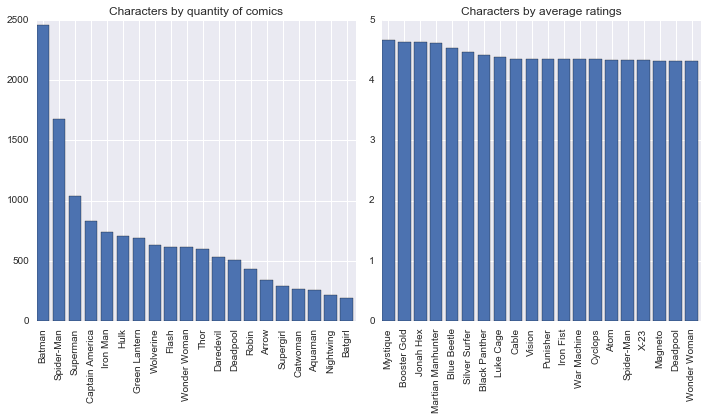

In [31]:
# Create charts related to the characters information
plt.figure(3,figsize=(10, 6))

plt.subplot(121) # Characters by quantity of comics
y_axis = top_characters_by_quantity['Quantity_of_comics']
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, tuple(top_characters_by_quantity['Character_Name']), 
                             rotation=90)
plt.title('Characters by quantity of comics')
plt.tight_layout()

plt.subplot(122) # Characters by average rating
y_axis = top_characters_by_rating['Average_Rating']
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, tuple(top_characters_by_rating['Character_Name']), 
                             rotation=90)
plt.title('Characters by average ratings')
plt.tight_layout()

plt.show()

And below, the charts for the teams:

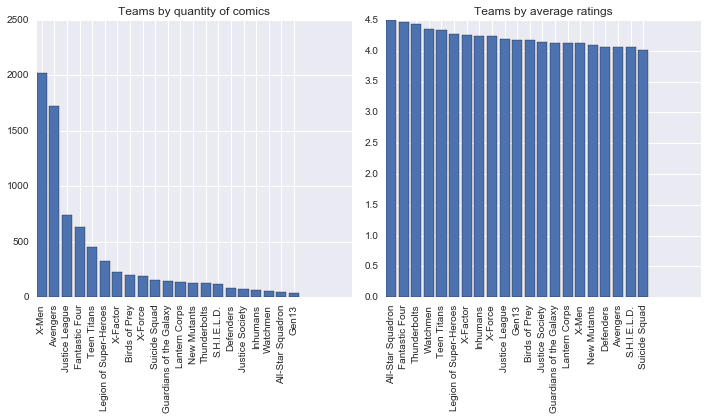

In [32]:
# Creation of charts related to teams
plt.figure(4,figsize=(10, 6))

plt.subplot(121) # Teams by quantity of comics
y_axis = top_teams_by_quantity['Quantity_of_comics']
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, tuple(top_teams_by_quantity['Team_Name']), rotation=90)
plt.title('Teams by quantity of comics')
plt.tight_layout()

plt.subplot(122) # Teams by average ratings
y_axis = top_teams_by_rating['Average_Rating']
x_axis = np.arange(len(y_axis))
plt.bar(x_axis, y_axis)
plt.xticks(x_axis+0.4, tuple(top_teams_by_rating['Team_Name']), rotation=90)
plt.title('Teams by average ratings')
plt.tight_layout()

plt.show()

## Conclusion

And with that, we conclude our series of 3 posts with the [analysis of the website](http://felipegalvao.com.br/blog/2016/05/01/comixology-digital-comics-analysis-part-1-analysis-of-site-for-web-scraping/), [web scraping](http://felipegalvao.com.br/blog/2016/05/24/web-scraping-with-python-scraping-digital-comics-information-from-comixology/) and [data analysis of digital comics](http://felipegalvao.com.br/blog/2016/06/06/digital-comics-analysis-python-marvel-or-dc-and-some-other-conclusions/), with information extracted from the [Comixology website](https://www.comixology.com/). As the data is not always available in a simple and practical manner, like a database or a csv dataset, sometimes we have to get the data through web scraping, or some other more complex technique.

In this analysis, we reached some conclusions related to the comics on the website. I made a summary of my conclusions on the list below:

* Some smaller publishers have a good average rating, probably being a good option if you want to read something different than the big ones (Marvel, DC Comics, Image, etc)
* Among the big ones (publishers with more than 300 comics rated on Comixology), Marvel and DC Comics are in the bottom of the ranking when it comes to average ratings of its comics. The three first ones are Archie (of Archie comics, Mega Man, Sonic, among others), MAX (focused in adult comics: Dexter, Jessica Jones, Deadpool) and Image - Skybound (mainly Walking Dead).
* Age Classifications does not seems to affect the rating a comic receives significantly.
* The number of releases of comics increased a lot in the decade of 2000, suffered a recent downfall and now seems to oscilate through the years.
* The two comics with most ratings on Comixology are free. The third, maybe surprisingly, is the first issue of the Saga series, from the publisher Image.
* In the private battle between Marvel and DC Comics, DC seems to have a small advantage. DC has a smaller average price per page and average price, while having a slightly higher average rating. The average page count is a little bigger on Marvel's comics. DC also has a bigger proportion of good comics (4 ou 5 stars rating) and a smaller proportion of bad comics (1 or 2 stars rating).
* Batman is the character with most comics, followed by Spider-Man and Superman. The heroes with the highest average rating are, surprisingly, Mystique (from X-Men), Booster Gold and Jonah Hex.
* Among the teams, the ones with most comics are the X-Men, Avengers and Justice League. On the podium for the highest average rating are All-Star Squadron from DC, Fantastic Four and Thunderbolts from Marvel.

And with that, we finish our small project. Hope everyone liked. :)

Regards!